In [1]:
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [4]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [5]:
# for file path
import natsort
import platform
import glob
import os

import cv2 as cv
from google.colab.patches import cv2_imshow # cv2_imshow(img)


In [6]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')

# https://commons.wikimedia.org/wiki/File:Vassily_Kandinsky,_1913_-_Composition_7.jpg
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')
content_image = load_img(content_path)
style_image = load_img(style_path)

204800/195196 [===============================] - 0s 0us/step


In [7]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [8]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

In [9]:
resnet50v2 = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet')

94683136/94668760 [==============================] - 1s 0us/step


In [10]:
content_layers = ['conv5_block3_1_conv'] 

style_layers = ['conv2_block1_1_conv',
'conv2_block2_1_conv',
'conv3_block1_1_conv',
'conv3_block2_1_conv',
'conv4_block1_1_conv',
'conv4_block2_1_conv',
'conv5_block1_1_conv',
'conv5_block2_1_conv'
]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [11]:
def resnet50v2_layers(layer_names):
  resnet50v2 = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet')
  resnet50v2.trainable = False

  outputs = [resnet50v2.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([resnet50v2.input], outputs)
  return model

In [12]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [13]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.resnet50v2 =  resnet50v2_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.resnet50v2.trainable = False

  def call(self, inputs):
    "[0,1] 사이의 실수 값을 입력으로 받습니다"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.resnet_v2.preprocess_input(inputs)
    outputs = self.resnet50v2(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

In [14]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('스타일:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    크기: ", output.numpy().shape)
  print("    최솟값: ", output.numpy().min())
  print("    최댓값: ", output.numpy().max())
  print("    평균: ", output.numpy().mean())
  print()

print("콘텐츠:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    크기: ", output.numpy().shape)
  print("    최솟값: ", output.numpy().min())
  print("    최댓값: ", output.numpy().max())
  print("    평균: ", output.numpy().mean())

스타일:
   conv2_block1_1_conv
    크기:  (1, 64, 64)
    최솟값:  -160.79054
    최댓값:  285.89954
    평균:  8.029386

   conv2_block2_1_conv
    크기:  (1, 64, 64)
    최솟값:  -2.2114253
    최댓값:  3.1866403
    평균:  0.0060812216

   conv3_block1_1_conv
    크기:  (1, 128, 128)
    최솟값:  -5.0140676
    최댓값:  7.7526135
    평균:  0.007340039

   conv3_block2_1_conv
    크기:  (1, 128, 128)
    최솟값:  -1.7390178
    최댓값:  2.0096266
    평균:  0.044565067

   conv4_block1_1_conv
    크기:  (1, 256, 256)
    최솟값:  -4.1237226
    최댓값:  5.770214
    평균:  0.009567199

   conv4_block2_1_conv
    크기:  (1, 256, 256)
    최솟값:  -1.1325629
    최댓값:  1.8558738
    평균:  0.07197705

   conv5_block1_1_conv
    크기:  (1, 512, 512)
    최솟값:  -0.50524294
    최댓값:  0.9105596
    평균:  0.065320745

   conv5_block2_1_conv
    크기:  (1, 512, 512)
    최솟값:  -2.274394
    최댓값:  2.8653712
    평균:  0.115823865

콘텐츠:
   conv5_block3_1_conv
    크기:  (1, 14, 16, 512)
    최솟값:  -1.8399397
    최댓값:  1.3853563
    평균:  -0.14509086


In [15]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [16]:
image = tf.Variable(content_image)

In [17]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [18]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [19]:
style_weight=1e20
content_weight=1e1

In [20]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [21]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

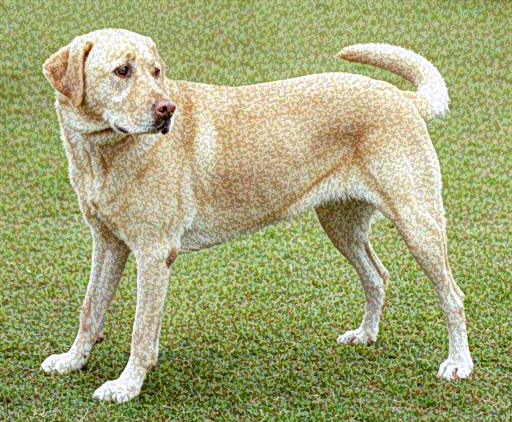

In [22]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

In [23]:
# Function to load an image from a file, and add a batch dimension.
def load_img(path_to_img):
  img = tf.io.read_file(path_to_img)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = img[tf.newaxis, :]

  return img

# Function to pre-process by resizing an central cropping it.
def preprocess_image(image, target_dim):
  # Resize the image so that the shorter dimension becomes 256px.
  shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
  short_dim = min(shape)
  scale = target_dim / short_dim
  new_shape = tf.cast(shape * scale, tf.int32)
  image = tf.image.resize(image, new_shape)

  # Central crop the image.
  image = tf.image.resize_with_crop_or_pad(image, target_dim, target_dim)

  return image

# Load the input images.
content_image = load_img(content_path)
style_image = load_img(style_path)

# Preprocess the input images.
preprocessed_content_image = preprocess_image(content_image, 384)
preprocessed_style_image = preprocess_image(style_image, 256)

print('Style Image Shape:', preprocessed_style_image.shape)
print('Content Image Shape:', preprocessed_content_image.shape)

Style Image Shape: (1, 256, 256, 3)
Content Image Shape: (1, 384, 384, 3)


In [24]:
content_path = tf.keras.utils.get_file('belfry.jpg','https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/belfry-2611573_1280.jpg')
style_path = tf.keras.utils.get_file('style23.jpg','https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/style23.jpg')

style_predict_path = tf.keras.utils.get_file('style_predict.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/prediction/1?lite-format=tflite')
style_transform_path = tf.keras.utils.get_file('style_transform.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/transfer/1?lite-format=tflite')

294912/284398 [===============================] - 0s 0us/step


In [25]:
# Function to run style prediction on preprocessed style image.
def run_style_predict(preprocessed_style_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_predict_path)

  # Set model input.
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  interpreter.set_tensor(input_details[0]["index"], preprocessed_style_image)

  # Calculate style bottleneck.
  interpreter.invoke()
  style_bottleneck = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return style_bottleneck

# Calculate style bottleneck for the preprocessed style image.
style_bottleneck = run_style_predict(preprocessed_style_image)
print('Style Bottleneck Shape:', style_bottleneck.shape)

Style Bottleneck Shape: (1, 1, 1, 100)


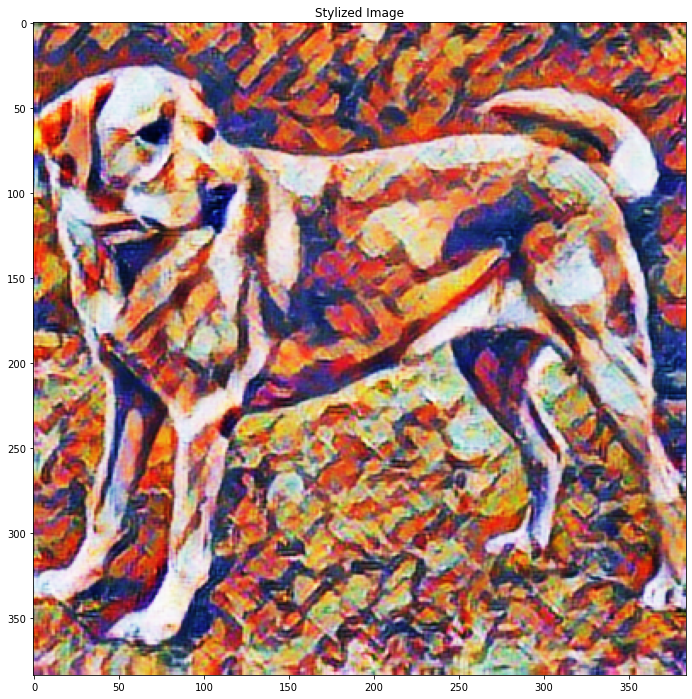

In [26]:
# Run style transform on preprocessed style image
def run_style_transform(style_bottleneck, preprocessed_content_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_transform_path)

  # Set model input.
  input_details = interpreter.get_input_details()
  interpreter.allocate_tensors()

  # Set model inputs.
  interpreter.set_tensor(input_details[0]["index"], preprocessed_content_image)
  interpreter.set_tensor(input_details[1]["index"], style_bottleneck)
  interpreter.invoke()

  # Transform content image.
  stylized_image = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return stylized_image

# Stylize the content image using the style bottleneck.
stylized_image = run_style_transform(style_bottleneck, preprocessed_content_image)

# Visualize the output.
imshow(stylized_image, 'Stylized Image')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


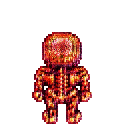

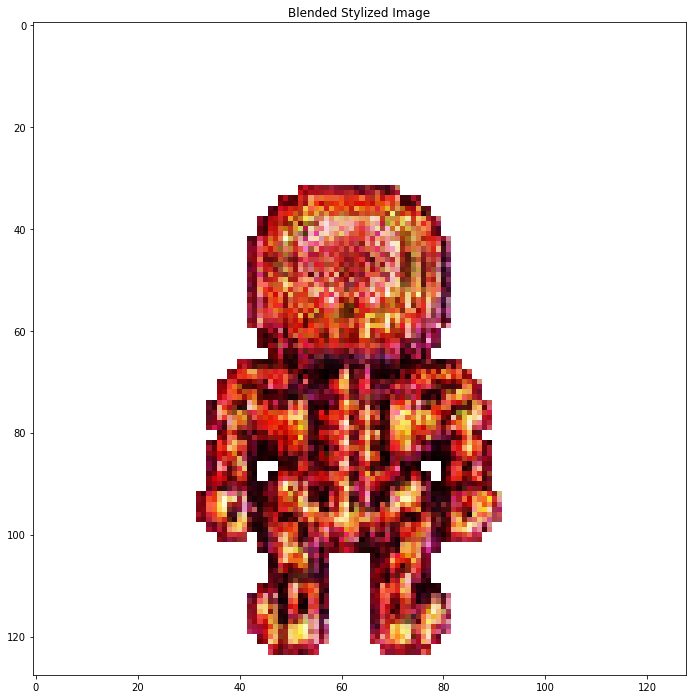

In [27]:
content_location = "/content/drive/Shareddrives/SWTube/프로젝트/044. 2021 소융튜브 특성화 프로젝트/데이터 팀/mount_drive/Darkest-Cave/Data/Content_Images/skeleton_128/sprite_00.png"
style_location = "/content/drive/Shareddrives/SWTube/프로젝트/044. 2021 소융튜브 특성화 프로젝트/데이터 팀/mount_drive/Darkest-Cave/Data/Style_Images/horror/horror27.jpg"

# 원본 파일의 크기를 알 수 있게 하는 코드
origin_image = cv.imread(content_location, cv.IMREAD_UNCHANGED)
origin_image_shape = origin_image.shape

# Load the input images.
content_image = load_img(content_location)
style_image = load_img(style_location)

# Preprocess the input images.
preprocessed_content_image = preprocess_image(content_image, 384)
preprocessed_style_image = preprocess_image(style_image, 256)

# Calculate style bottleneck for the preprocessed style image.
style_bottleneck = run_style_predict(preprocessed_style_image)

img_transformed = run_style_transform(style_bottleneck, preprocessed_content_image)

# model이 반환한 이미지와 사이즈 동일하게 origin image 변환(자동화 완료)
shape = preprocessed_content_image.shape[1]
x, y = shape, shape
origin_image_resized = cv.resize(origin_image, dsize=(y,x))

# alpha channel 추가
final = cv.cvtColor(img_transformed[0], cv.COLOR_RGB2RGBA)

final[:, :, 3] = origin_image_resized[:,:,3]

# final image 사이즈를 original image 사이즈로 변환
x, y = origin_image_shape[0], origin_image_shape[1]
final = cv.resize(final, dsize=(y,x))

# Visualize the output.
imshow(final, 'Blended Stylized Image')

# float to int 클리핑 (약간의 이미지 깨짐 현상 있음)
final = (final * 255).astype(np.uint)

# plt 기준의 bgr을 cv 기준의 rgb로 변경
b, g, r, a = cv.split(final)
final = cv.merge([r,g,b,a])

cv2_imshow(final)

In [28]:
# 경로 설정 명세서
platform_path = platform.platform()

IsColab = "bionic" in platform_path
if IsColab:
  style_location = "/content/drive/Shareddrives/SWTube/프로젝트/044. 2021 소융튜브 특성화 프로젝트/데이터 팀/mount_drive/Darkest-Cave/Data/Style_Images/*"
  content_location = "/content/drive/Shareddrives/SWTube/프로젝트/044. 2021 소융튜브 특성화 프로젝트/데이터 팀/mount_drive/Darkest-Cave/Data/Content_Images/*"
  styled_location = "/content/drive/Shareddrives/SWTube/프로젝트/044. 2021 소융튜브 특성화 프로젝트/데이터 팀/mount_drive/Darkest-Cave/Data/Styled_Images/"
else:
  style_location = 'Style_Images/*'
  content_location = "Content_Images/*"
  styled_location = "Styled_Images/"

# 해당 폴더 내에 존재하는 모든 폴더 리스트 불러오기
style_folder_list = glob.glob(style_location)
style_images_list = glob.glob(style_folder_list[0] + "/*")

# Style_location
# Style_Images/TEXTURE/*.jpg or png

# style_images_list, style_image 활용
# style_image = style_images_list[index]

# Content_location
  # Content_Images/ASSET_NAME/*.png
content_folder_list = glob.glob(content_location) # Content_Images/ASSET_NAME

# content_images_list, content_image 활용
# content_images_list = glob.glob(content_folder_list[index] + "/*")
# content_image = style_images_list[index]

# Styled_location
  # Styled_Images/ASSET_NAME/*.png
# asset_name = os.path.split(content_folder_list[index])

# 폴더 생성
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

In [ ]:
## main code
import time
start = time.time()

# ★사용 모델명★
model_name = "ResNet50V2"

# 스타일 폴더 리스트
for SF_index, SF_value in enumerate(style_folder_list):
  style_images_list = glob.glob(style_folder_list[SF_index] + "/*")
  style_folder_name = os.path.split(style_folder_list[SF_index]) # horror, ice, dark .etc

  style_images_list = natsort.natsorted(style_images_list)

  # 스타일 이미지 리스트
  for SI_index, SI_value in enumerate(style_images_list):
    style_image_name = os.path.split(style_images_list[SI_index]) # horror1, horror2, horror3, .etc
    
    # 스타일 이미지 선택
    print(SI_value)
    style_image = load_img(SI_value)
    preprocessed_style_image = preprocess_image(style_image, 256)

    # 콘텐트 폴더 리스트
    for CF_index, CF_value in enumerate(content_folder_list):

      #콘텐트 이미지 리스트
      content_images_list = glob.glob(content_folder_list[CF_index] + "/*")
      content_images_list = natsort.natsorted(content_images_list)

      # 스타일 전이
      for CI_index, CI_value in enumerate(content_images_list):

        # 저장 경로 생성
        asset_folder = os.path.split(content_folder_list[CF_index]) # gobline, zombie, male .etc
        asset_name = os.path.split(CI_value)

        save_folder_model = styled_location + model_name
        save_folder_style = save_folder_model + "/" + style_folder_name[1]
        save_folder_style_index = save_folder_style + "/" + style_image_name[1]
        save_folder_style_index_content = save_folder_style_index + "/" + asset_folder[1]
        
        createFolder(save_folder_style) # VGG19, AdaIN, efficientNet
        createFolder(save_folder_style) # horror, ice, dark
        createFolder(save_folder_style_index) # horror1, horror2, horror3
        createFolder(save_folder_style_index_content) # goblin, zombie, male

        save_path = save_folder_style_index_content + "/"
        save_path = save_path + asset_name[1] + f'_{CI_index}_final.png'

        # 이미 있는 파일이면 건너뛰기
        if os.path.exists(save_path):
          continue
        else:
          try:
            # 원본 파일의 크기를 알 수 있게 하는 코드
            origin_image = cv.imread(CI_value, cv.IMREAD_UNCHANGED)
            origin_image_shape = origin_image.shape

            # Load the input images.
            content_image = load_img(CI_value)

            # Preprocess the input images.
            preprocessed_content_image = preprocess_image(content_image, 384)
          
            # Calculate style bottleneck for the preprocessed style image.
            style_bottleneck = run_style_predict(preprocessed_style_image)
            img_transformed = run_style_transform(style_bottleneck, preprocessed_content_image)

            # model이 반환한 이미지와 사이즈 동일하게 origin image 변환(자동화 완료)
            shape = preprocessed_content_image.shape[1]
            x, y = shape, shape
            origin_image_resized = cv.resize(origin_image, dsize=(y,x))

            # alpha channel 추가
            final = cv.cvtColor(img_transformed[0], cv.COLOR_RGB2RGBA)
            final[:, :, 3] = origin_image_resized[:,:,3]

            # final image 사이즈를 original image 사이즈로 변환
            x, y = origin_image_shape[0], origin_image_shape[1]
            final = cv.resize(final, dsize=(y,x))

            # float to int 클리핑 (약간의 이미지 깨짐 현상 있음)
            final = (final * 255).astype(np.uint)

            # plt 기준의 bgr을 cv 기준의 rgb로 변경
            b, g, r, a = cv.split(final)
            final = cv.merge([r,g,b,a])
          
            # 저장
            cv.imwrite(save_path, final)
          except:
            print(CI_value)
            pass

end = time.time()
print("전체 소요 시간: {:.1f}".format(end-start))

/content/drive/Shareddrives/SWTube/프로젝트/044. 2021 소융튜브 특성화 프로젝트/데이터 팀/mount_drive/Darkest-Cave/Data/Style_Images/horror/horror1.jpg
/content/drive/Shareddrives/SWTube/프로젝트/044. 2021 소융튜브 특성화 프로젝트/데이터 팀/mount_drive/Darkest-Cave/Data/Content_Images/crocodile_32/buff_totem_32
/content/drive/Shareddrives/SWTube/프로젝트/044. 2021 소융튜브 특성화 프로젝트/데이터 팀/mount_drive/Darkest-Cave/Data/Content_Images/crocodile_32/buff_totem_64
/content/drive/Shareddrives/SWTube/프로젝트/044. 2021 소융튜브 특성화 프로젝트/데이터 팀/mount_drive/Darkest-Cave/Data/Content_Images/crocodile_32/fire_totem_32
/content/drive/Shareddrives/SWTube/프로젝트/044. 2021 소융튜브 특성화 프로젝트/데이터 팀/mount_drive/Darkest-Cave/Data/Content_Images/crocodile_32/fire_totem_64
/content/drive/Shareddrives/SWTube/프로젝트/044. 2021 소융튜브 특성화 프로젝트/데이터 팀/mount_drive/Darkest-Cave/Data/Content_Images/crocodile_32/heal_totem_32
/content